# Create mock for DiagISM
In this notebook we create a mock sample of galaxies to capture the behaviour of the DiagISM prediction in a simple polynomial fit. First, we import the Python packages.

In [1]:
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from astropy.table import Table

from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor

## Read the data
We read the original dataset and estimate and organise the columns we want to use

In [2]:
dataset = Table.read('../data/raw/complete_dataset.fits', format='fits')

In [3]:
dataset['log(1+z)'] = np.log10(dataset['z']+1)

In [4]:
col_analt = dataset.colnames[3:-15:5]
col_analt.append('log(1+z)')

We focus on SFR, therefore we scale the luminosity columns and use the hyperparameters that we found for the MLP to train the model again

In [5]:
X = dataset[col_analt[:]].to_pandas()
y = dataset.to_pandas()['SFR'].values.reshape(-1, 1)

In [6]:
scalerX = preprocessing.RobustScaler()
scalery = preprocessing.RobustScaler()
X_scale = scalerX.fit_transform(X)
y_scale = scalery.fit_transform(y)

In [7]:
hyper_sfr = Table.read('../data/interim/Hyperparameters_table.csv',
                       format='ascii')[0]

In [8]:
regrMLP = MLPRegressor(random_state=42, verbose=True,
                       hidden_layer_sizes=literal_eval(
                           hyper_sfr['hidden_layer_sizes']),
                       activation=hyper_sfr['activation'],
                       solver='adam',
                       alpha=hyper_sfr['alpha'],
                       batch_size=hyper_sfr['batch_size'],
                       learning_rate_init=hyper_sfr['learning_rate_init'],
                       max_iter=hyper_sfr['max_iter'])
regrMLP.fit(X_scale, y_scale.ravel())

Iteration 1, loss = 0.03913190
Iteration 2, loss = 0.01962348
Iteration 3, loss = 0.01719373
Iteration 4, loss = 0.01574484
Iteration 5, loss = 0.01468615
Iteration 6, loss = 0.01390350
Iteration 7, loss = 0.01369199
Iteration 8, loss = 0.01412658
Iteration 9, loss = 0.01372223
Iteration 10, loss = 0.01369816
Iteration 11, loss = 0.01299795
Iteration 12, loss = 0.01268916
Iteration 13, loss = 0.01290012
Iteration 14, loss = 0.01275526
Iteration 15, loss = 0.01251909
Iteration 16, loss = 0.01226562
Iteration 17, loss = 0.01225945
Iteration 18, loss = 0.01217899
Iteration 19, loss = 0.01258665
Iteration 20, loss = 0.01202941
Iteration 21, loss = 0.01172954
Iteration 22, loss = 0.01202667
Iteration 23, loss = 0.01197181
Iteration 24, loss = 0.01170097
Iteration 25, loss = 0.01204780
Iteration 26, loss = 0.01260499
Iteration 27, loss = 0.01157235
Iteration 28, loss = 0.01152638
Iteration 29, loss = 0.01167832
Iteration 30, loss = 0.01132595
Iteration 31, loss = 0.01122211
Iteration 32, los

MLPRegressor(alpha=0.0002, batch_size=195, hidden_layer_sizes=(100, 83, 77),
             learning_rate_init=0.002, max_iter=500, random_state=42,
             verbose=True)

## Create mock catalog
We create the mock catalog with one million galaxies. We assume that the luminosities are distributed between $10^2$ and $10^9$ solar luminosities

In [9]:
NROWS = int(1e6)

Text(0.5, 0, 'Luminosities [Lsun]')

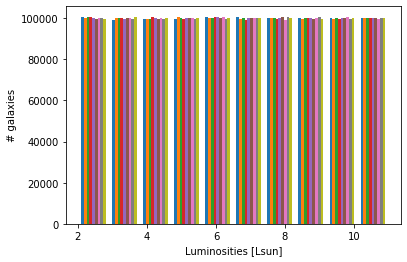

In [10]:
Lmock = np.random.random(size=(NROWS, 9))*9 + 2
plt.hist(Lmock)
plt.ylabel('# galaxies')
plt.xlabel('Luminosities [Lsun]')

We assume that luminosities need to be related with the relative distance to the [C II] line luminosity. Therefore, we shift the luminosities according to their apparent luminosity difference.

In [11]:
info = dataset[col_analt].to_pandas().describe(include='all')

In [12]:
info.loc['mean'][6] - info.loc['mean'][:-1]

L$_{\mathrm{OIII_{52}}}$    0.069576
L$_{\mathrm{NIII_{57}}}$    0.514572
L$_{\mathrm{OI_{63}}}$      0.171130
L$_{\mathrm{OIII_{88}}}$   -0.092554
L$_{\mathrm{NII_{122}}}$    1.390504
L$_{\mathrm{OI_{145}}}$     1.389859
L$_{\mathrm{CII}}$          0.000000
L$_{\mathrm{NII_{205}}}$    1.531745
Name: mean, dtype: float64

In [13]:
mock_z = np.log10(np.random.randint(7, size=NROWS)+1)
Lmock[:, -1] = mock_z
Lmock[:, 6] += (info.loc['mean'][6] - np.mean(Lmock[:, 6]))
for col in range(8):
    if col in [4, 5, 7]:
        Lmock[:, col] = Lmock[:, 6] - 1.5 + \
            (2*np.random.random(size=NROWS) - 1)
    elif col in [1]:
        Lmock[:, col] = Lmock[:, 6] - 0.5 + \
            (2*np.random.random(size=NROWS) - 1)
    elif col in [6]:
        continue
    else:
        Lmock[:, col] = Lmock[:, 6] + (2*np.random.random(size=NROWS) - 1)
    print(col)

0
1
2
3
4
5
7


We check the luminosity and redshift values again (The difference is that now we added the redshift column)

Text(0.5, 0, 'Luminosities [Lsun]')

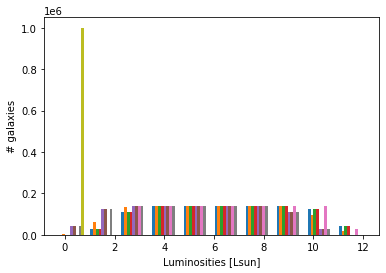

In [14]:
plt.hist(Lmock)
plt.ylabel('# galaxies')
plt.xlabel('Luminosities [Lsun]')

We rescale and predict the luminosities

In [15]:
Xmock_scaled = scalerX.transform(Lmock)

/Users/users/ramos/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [16]:
mock_predict = regrMLP.predict(Xmock_scaled)

In [17]:
trans_mock = scalery.inverse_transform(mock_predict.reshape(-1, 1))

We create plots to show how will be the behaviour of the mock sample in general (with a given redshift range)

In [18]:
localUmock = Lmock.T[8] >= 0.6

In [19]:
localUsim = X['log(1+z)'] >= 0.6

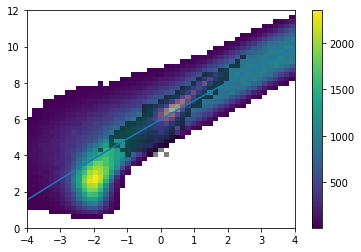

In [20]:
plt.hist2d(x=trans_mock.ravel()[localUmock], y=Lmock.T[1].ravel()[localUmock],
           bins=[np.linspace(-4, 4), np.linspace(0, 12)], cmin=10)
plt.colorbar()
plt.hist2d(x=y.ravel()[localUsim], y=X[X.columns[1]].ravel()[localUsim],
           bins=[np.linspace(-4, 4), np.linspace(0, 12)],
           alpha=0.5, cmap='magma', cmin=1)
fitz = np.poly1d(np.polyfit(trans_mock.ravel()[
                 localUmock], Lmock.T[1].ravel()[localUmock], 2))
xp = np.linspace(-4, 4)
plt.plot(xp, fitz(xp), '-')

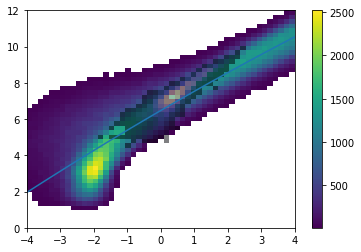

In [21]:
plt.hist2d(x=trans_mock.ravel()[localUmock], y=Lmock.T[3].ravel()[localUmock],
           bins=[np.linspace(-4, 4), np.linspace(0, 12)], cmin=10)
plt.colorbar()
plt.hist2d(x=y.ravel()[localUsim], y=X[X.columns[3]].ravel()[localUsim],
           bins=[np.linspace(-4, 4), np.linspace(0, 12)],
           alpha=0.5, cmap='magma', cmin=1)
fitz = np.poly1d(np.polyfit(trans_mock.ravel()[
                 localUmock], Lmock.T[3].ravel()[localUmock], 2))
xp = np.linspace(-4, 4)
plt.plot(xp, fitz(xp), '-')

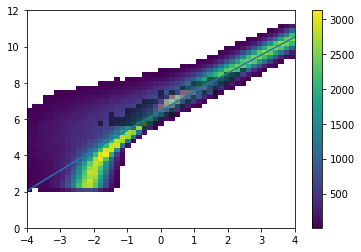

In [22]:
plt.hist2d(x=trans_mock.ravel()[localUmock], y=Lmock.T[6].ravel()[localUmock],
           bins=[np.linspace(-4, 4), np.linspace(0, 12)], cmin=10)
plt.colorbar()
plt.hist2d(x=y.ravel()[localUsim], y=X[X.columns[6]].ravel()[localUsim],
           bins=[np.linspace(-4, 4), np.linspace(0, 12)],
           alpha=0.5, cmap='magma', cmin=1)
fitz = np.poly1d(np.polyfit(trans_mock.ravel()[
                 localUmock], Lmock.T[6].ravel()[localUmock], 2))
xp = np.linspace(-4, 4)
plt.plot(xp, fitz(xp), '-')

Finally, we reorganize and save the values as the mock sample

In [23]:
pd_mock = pd.DataFrame(Lmock, columns=("logLOIII_51", "logLNIII_57", "logLOI_63",
                                       "logLOIII_88", "logLNII_122", "logLOI_145",
                                       "logLCII", "logLNII_205", "log_1plusz"))

In [24]:
pd_mock["logSFR"] = trans_mock

In [25]:
pd_mock = pd_mock[["log_1plusz", "logSFR", "logLOIII_51", "logLNIII_57", "logLOI_63",
                   "logLOIII_88", "logLNII_122", "logLOI_145",
                   "logLCII", "logLNII_205"]]

**WARNING, the mock_sample file is saved locally as the size is higher than 100 Mb**

In [26]:
pd_mock.to_csv('../data/interim/mock_sample.csv')

## Obtaining the polynomial regression
We use `R` to obtain the coefficients of the polynomial regression for the mock sample. Therefore we first load `R` and then we read the mock file.

In [2]:
%load_ext rpy2.ipython

In [28]:
%%R -o tableLum
tableLum <- read.csv(file = '../data/interim/mock_sample.csv')

In [29]:
%R print(colnames(tableLum))

 [1] "X"           "log_1plusz"  "logSFR"      "logLOIII_51" "logLNIII_57"
 [6] "logLOI_63"   "logLOIII_88" "logLNII_122" "logLOI_145"  "logLCII"    
[11] "logLNII_205"


'X','log_1plu...,'logSFR',...,'logLOI_1...,'logLCII','logLNII_...


We adjust the model to the data

In [30]:
%%R -o vect
vect = c()
for(em_line in 4:ncol(tableLum)){
    model <- lm(tableLum[[em_line]] ~ logSFR + log_1plusz + logSFR*log_1plusz + I(logSFR^2), data = tableLum)
    print(summary(model))
    coef <- summary(model)$coefficients[1:10] #This number changes # with variables (#+1 * 2)
    rse <- sqrt(deviance(model)/df.residual(model))
    vect = c(vect, c(coef, rse))}


Call:
lm(formula = tableLum[[em_line]] ~ logSFR + log_1plusz + logSFR * 
    log_1plusz + I(logSFR^2), data = tableLum)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5054 -0.6862 -0.0553  0.5962  5.7957 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        6.2272316  0.0024821 2508.87   <2e-16 ***
logSFR             1.1756844  0.0011179 1051.70   <2e-16 ***
log_1plusz         0.3919644  0.0038426  102.01   <2e-16 ***
I(logSFR^2)       -0.0241508  0.0002364 -102.17   <2e-16 ***
logSFR:log_1plusz -0.1212453  0.0016932  -71.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.043 on 999995 degrees of freedom
Multiple R-squared:  0.8465,	Adjusted R-squared:  0.8465 
F-statistic: 1.379e+06 on 4 and 999995 DF,  p-value: < 2.2e-16


Call:
lm(formula = tableLum[[em_line]] ~ logSFR + log_1plusz + logSFR * 
    log_1plusz + I(logSFR^2), data = tableLum)

Residuals:
    Min      1Q  Medi

We print coefficients for each line in a table format

In [31]:
r_outputs = vect.reshape(8, 11)  # (+1 of coefficients in previous cell)
Tcoef = Table(r_outputs, names=('Intercept',  'cSFR', 'clogz', 'cSFR2', 'cSFRlogz',
                                'Intercept_err', 'cSFR_err', 'clogz_err', 'cSFR2_err', 'cSFRlogz_err',
                                'sigma'))
for col in Tcoef.columns:
    Tcoef[col].info.format = '1.3f'
Tcoef.add_column(tableLum.columns[-8:], name='line', index=0)
Tcoef['line', 'Intercept', 'Intercept_err',  'cSFR', 'cSFR_err', 'cSFR2', 'cSFR2_err',
      'clogz', 'clogz_err',  'cSFRlogz', 'cSFRlogz_err', 'sigma']

line,Intercept,Intercept_err,cSFR,cSFR_err,cSFR2,cSFR2_err,clogz,clogz_err,cSFRlogz,cSFRlogz_err,sigma
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
logLOIII_51,6.227,0.002,1.176,0.001,-0.024,0.000,0.392,0.004,-0.121,0.002,1.043
logLNIII_57,5.740,0.003,1.172,0.001,-0.026,0.000,0.393,0.004,-0.133,0.002,1.110
logLOI_63,6.245,0.002,1.229,0.001,-0.032,0.000,0.411,0.003,-0.153,0.001,0.894
logLOIII_88,6.241,0.002,1.187,0.001,-0.028,0.000,0.401,0.004,-0.126,0.002,1.029
logLNII_122,4.741,0.002,1.206,0.001,-0.029,0.000,0.402,0.003,-0.122,0.001,0.911
logLOI_145,4.662,0.003,1.137,0.001,-0.007,0.000,0.365,0.004,-0.130,0.002,1.132
logLCII,6.228,0.002,1.176,0.001,-0.024,0.000,0.391,0.003,-0.130,0.001,0.893
logLNII_205,4.650,0.003,1.135,0.001,-0.005,0.000,0.369,0.004,-0.143,0.002,1.162


We plot some of the comparison with the previous line regressions

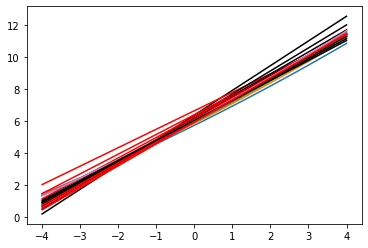

In [32]:
# [NIII]57
NLINE = 1
x = np.linspace(-4, 4)
z = np.log10(1 + np.arange(0, 7))
for red in z:
    plt.plot(x, Tcoef['Intercept'][NLINE] + Tcoef['cSFR'][NLINE]*x -
             Tcoef['cSFR2'][NLINE]*x**2 + red*Tcoef['clogz'][NLINE] -
             Tcoef['cSFRlogz'][NLINE]*red*x)
#     if red==np.log10(7):
#         print((6.627 + 0.801*x + 0.033*x**2 + red*0.093 - 0.058*red*x)[::7])
    plt.plot(x, 6.38 + (1.54*x) - (red*0.39) - (0.35*red*x), c='k')
    plt.plot(x, 6.65 + (1.15*x) - (red*0.82) + (0.26*red*x), c='r')

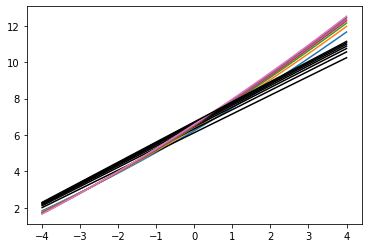

In [33]:
# [OI]63
NLINE = 2
x = np.linspace(-4, 4)
z = np.log10(1 + np.arange(0, 7))
for red in z:
    plt.plot(x, Tcoef['Intercept'][NLINE] + Tcoef['cSFR'][NLINE]*x -
             Tcoef['cSFR2'][NLINE]*x**2 + red*Tcoef['clogz'][NLINE] -
             Tcoef['cSFRlogz'][NLINE]*red*x)
    plt.plot(x, 6.13 + (1.03*x) + (red*0.70) + (0.09*red*x), c='k')

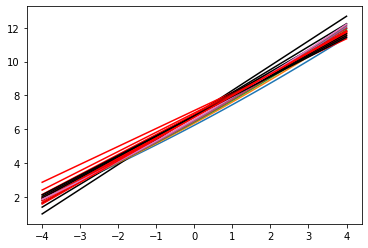

In [34]:
# [OIII]88
NLINE = 3
x = np.linspace(-4, 4)
z = np.log10(1 + np.arange(0, 7))
for red in z:
    plt.plot(x, Tcoef['Intercept'][NLINE] + Tcoef['cSFR'][NLINE]*x -
             Tcoef['cSFR2'][NLINE]*x**2 + red*Tcoef['clogz'][NLINE] -
             Tcoef['cSFRlogz'][NLINE]*red*x)
#     if red==np.log10(7):
#         print((6.627 + 0.801*x + 0.033*x**2 + red*0.093 - 0.058*red*x)[::7])
    plt.plot(x, 6.84 + (1.46*x) - (red*0.07) - (0.35*red*x), c='k')
    plt.plot(x, 7.11 + (1.06*x) - (red*0.48) + (0.26*red*x), c='r')

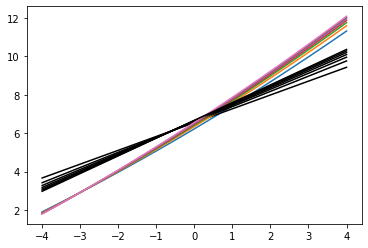

In [35]:
# [CII]
NLINE = 6
x = np.linspace(-4, 4)
z = np.log10(1 + np.arange(0, 7))
for red in z:
    plt.plot(x, Tcoef['Intercept'][NLINE] + Tcoef['cSFR'][NLINE]*x -
             Tcoef['cSFR2'][NLINE]*x**2 + red*Tcoef['clogz'][NLINE] -
             Tcoef['cSFRlogz'][NLINE]*red*x)
    plt.plot(x, 6.55 + (0.72*x) + (red*0.14) + (0.24*red*x), c='k')

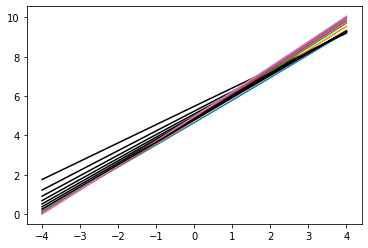

In [36]:
# [NII]205
NLINE = 7
x = np.linspace(-4, 4)
z = np.log10(1 + np.arange(0, 7))
for red in z:
    plt.plot(x, Tcoef['Intercept'][NLINE] + Tcoef['cSFR'][NLINE]*x -
             Tcoef['cSFR2'][NLINE]*x**2 + red*Tcoef['clogz'][NLINE] -
             Tcoef['cSFRlogz'][NLINE]*red*x)
    plt.plot(x, 5.48 + (0.93*x) - (red*0.82) + (0.24*red*x), c='k')

Finally, we save the information in tables to be used later on. We use the .tex and .csv format

In [37]:
Tcoef['line', 'Intercept', 'Intercept_err',
      'cSFR', 'cSFR_err', 'cSFR2', 'cSFR2_err',
      'clogz', 'clogz_err',  'cSFRlogz', 'cSFRlogz_err',
      'sigma'].write('../data/interim/coeff_MLPreg.csv',
                     format='ascii.csv',
                     overwrite=True)

In [38]:
Tcoef['line', 'Intercept', 'cSFR',
      'clogz', 'cSFRlogz', 'cSFR2',
      'sigma'].write('../data/interim/coeff_MLPreg_latex.tex',
                     format='latex',
                     overwrite=True)

##### Notebook information

In [4]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w -p rpy2

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.59.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
rpy2: 3.4.5

matplotlib: 3.4.3
autopep8  : 1.5.7
json      : 2.0.9
sklearn   : 1.0.1
numpy     : 1.22.1
pandas    : 1.4.0

Watermark: 2.2.0



In [40]:
%%R
print(sessionInfo())
print(version)

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: Scientific Linux 7.9 (Nitrogen)

Matrix products: default
BLAS/LAPACK: /Software/users/modules/7/software/anaconda3/2020.07/lib/libmkl_intel_lp64.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_3.6.0
               _                           
platform       x86_64-redhat-linux-gnu     
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
statu